# Homework 01 

This Jupyter Notebook file is a template that we provide for the homework.
You _must_ use this template and follow the instructions.
To unify the submission, we require you to store specific intermediate results into _"submission-variables"_.
These values are printed at the _end_ of the jupyter notebook and will be (partially) used to grade your assignment.
Please ensure that these variables have the correct values and aren't overwritten by following code-cells.

In [1]:
# used for submission variables
from copy import deepcopy

## Sentinel-2 tile download

Download a Sentinel-2 tile from [SciHub Copernicus](https://scihub.copernicus.eu/dhus/#/home) with the following requirements:
- With the sensing date _after_ 01.03.2022
- With the product-type `S2MSI2A`
- _At least_ a cloud cover percentage of 1% but _no more_ than 20%
- Not the tile with the id: 
    - `6e5ad1c9-fc0e-4b93-9b5c-d0d401673206`

_Write_ down (inside of a markdown cell) a city that is part of the downloaded Sentinel-2 tile!

To ensure that no secrets are shared, please use the following code template.
You can create a [TOML](https://en.wikipedia.org/wiki/TOML) file called `.secrets.toml` with the contents:

```toml

scihub_copernicus_user = "<YOUR_PWD>"
scihub_copernicus_pwd = "<YOUR_PWD>"
```

Or you can simply remove your username/password _after_ executing the notebook and _before_ submitting it.

In [2]:
# KEEP
from dynaconf import Dynaconf

settings = Dynaconf(
    envvar_prefix="IP4RS",
    settings_files=["settings.toml", ".secrets.toml"],
)

SENTINEL_API_URL = "https://scihub.copernicus.eu/dhus"
YOUR_USERNAME = "kton"
YOUR_PWD = "12345678"
user = settings.get("scihub_copernicus_user", default=YOUR_USERNAME)
pwd = settings.get("scihub_copernicus_pwd", default=YOUR_PWD)

assert user != r""
assert pwd != r""
###

In [4]:
# imports
import numpy as np
import geopandas
from pathlib import Path
import osmnx


from sentinelsat import SentinelAPI
from datetime import date
from shapely.geometry import Point
import rasterio
import zipfile

from enum import Enum
from typing import List, Sequence
import matplotlib.pyplot as plt

import rasterio.mask


In [5]:
# Get lats and longs
latitude = 52.112230
longitude = 13.327135



In [6]:
series = geopandas.GeoSeries([Point(longitude, latitude)], crs="EPSG:4326")
series



0    POINT (13.32714 52.11223)
dtype: geometry

In [7]:
api_sent = SentinelAPI(user, pwd, SENTINEL_API_URL)
# api_sent.query?

In [8]:
series.to_wkt()


0    POINT (13.327135 52.11223)
dtype: object

In [9]:
poi = series.to_wkt()[0]
poi



'POINT (13.327135 52.11223)'

In [10]:
# Set params
start_date = date(year=2022, month=3, day=1)
end_date = date(year=2022, month=4, day=30)
satellite = "Sentinel-2"
producttype = "S2MSI2A"

products = api_sent.query(
    poi,
    date=(start_date, end_date),
    platformname=satellite,
    producttype=producttype,
    cloudcoverpercentage=(1, 20),
)

# convert to GeoPandas GeoDataFrame
products_gdf = api_sent.to_geodataframe(products)
assert not products_gdf.empty
products_gdf.head(1)
# If you get an internal-service error, simply try again




title  \
0de0c49b-72d0-4ff9-9605-79c51399d676  S2B_MSIL2A_20220423T100549_N0400_R022_T33UUT_2...   

                                                                                   link  \
0de0c49b-72d0-4ff9-9605-79c51399d676  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
0de0c49b-72d0-4ff9-9605-79c51399d676  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
0de0c49b-72d0-4ff9-9605-79c51399d676  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                                summary  \
0de0c49b-72d0-4ff9-9605-79c51399d676  Date: 2022-04-23T10:05:49.024Z, Instrument: MS...   

                                     ondemand      generationdate  \
0de0c49b-72d0-4ff9-9605-79c51399d676    false 2022-04-23 13:43:29   

                                               beginposition  \
0de0c49b-72d0-4ff9-9605-79c51399d676 2022-04-23 10:05:49.024   

                                                 endposition  \
0de0c49b-72d0-4ff9-9605-79c51399d676 2022-04-23 10:05:49.024   

                                               ingestiondate  ...  \
0de0c49b-72d0-4ff9-9605-79c51399d676 2022-04-23 17:44:37.025  ...   

                                      producttype  platformidentifier  \
0de0c49b-72d0-4ff9-9605-79c51399d676      S2MSI2A           2017-013A   

                                      orbitdirection  \
0de0c49b-72d0-4ff9-9605-79c51399d676      DESCENDING   

                                      platformserialidentifier  \
0de0c49b-72d0-4ff9-9605-79c51399d676               Sentinel-2B   

                                      processinglevel  \
0de0c49b-72d0-4ff9-9605-79c51399d676         Level-2A   

                                                                    datastripidentifier  \
0de0c49b-72d0-4ff9-9605-79c51399d676  S2B_OPER_MSI_L2A_DS_VGS2_20220423T134329_S2022...   

                                                                      granuleidentifier  \
0de0c49b-72d0-4ff9-9605-79c51399d676  S2B_OPER_MSI_L2A_TL_VGS2_20220423T134329_A0267...   

                                                                             identifier  \
0de0c49b-72d0-4ff9-9605-79c51399d676  S2B_MSIL2A_20220423T100549_N0400_R022_T33UUT_2...   

                                                                      uuid  \
0de0c49b-72d0-4ff9-9605-79c51399d676  0de0c49b-72d0-4ff9-9605-79c51399d676   

                                                                               geometry  
0de0c49b-72d0-4ff9-9605-79c51399d676  MULTIPOLYGON (((12.12921 51.32805, 13.70458 51...  

[1 rows x 41 columns]

In [11]:
# The tile-id should be generated here
# for example:
tile_id = "0de0c49b-72d0-4ff9-9605-79c51399d676"



In [12]:
# sort and select the first row
product = products_gdf.sort_values(
    ["cloudcoverpercentage", "ingestiondate"], ascending=[True, True]
).head(1)
product
print(product["title"][0])

S2B_MSIL2A_20220324T100649_N0400_R022_T32UQC_20220324T132305


In [13]:
# ensuring that the tile is the one we are also providing via a direct
# download link
assert product["title"][0] == "S2B_MSIL2A_20220324T100649_N0400_R022_T32UQC_20220324T132305"

In [14]:
# Would fail, because there are entries that cannot be JSON encoded!
# product.explore()
# Only visualize the relevant columns and convert them if necessary
product[["title", "summary", "geometry"]].explore()

In [15]:
product

title  \
bbd5d330-b017-4ae3-b669-2a2a0768272b  S2B_MSIL2A_20220324T100649_N0400_R022_T32UQC_2...   

                                                                                   link  \
bbd5d330-b017-4ae3-b669-2a2a0768272b  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
bbd5d330-b017-4ae3-b669-2a2a0768272b  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
bbd5d330-b017-4ae3-b669-2a2a0768272b  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                                summary  \
bbd5d330-b017-4ae3-b669-2a2a0768272b  Date: 2022-03-24T10:06:49.024Z, Instrument: MS...   

                                     ondemand      generationdate  \
bbd5d330-b017-4ae3-b669-2a2a0768272b    false 2022-03-24 13:23:05   

                                               beginposition  \
bbd5d330-b017-4ae3-b669-2a2a0768272b 2022-03-24 10:06:49.024   

                                                 endposition  \
bbd5d330-b017-4ae3-b669-2a2a0768272b 2022-03-24 10:06:49.024   

                                               ingestiondate  ...  \
bbd5d330-b017-4ae3-b669-2a2a0768272b 2022-03-24 16:36:45.886  ...   

                                      producttype  platformidentifier  \
bbd5d330-b017-4ae3-b669-2a2a0768272b      S2MSI2A           2017-013A   

                                      orbitdirection  \
bbd5d330-b017-4ae3-b669-2a2a0768272b      DESCENDING   

                                      platformserialidentifier  \
bbd5d330-b017-4ae3-b669-2a2a0768272b               Sentinel-2B   

                                      processinglevel  \
bbd5d330-b017-4ae3-b669-2a2a0768272b         Level-2A   

                                                                    datastripidentifier  \
bbd5d330-b017-4ae3-b669-2a2a0768272b  S2B_OPER_MSI_L2A_DS_VGS2_20220324T132305_S2022...   

                                                                      granuleidentifier  \
bbd5d330-b017-4ae3-b669-2a2a0768272b  S2B_OPER_MSI_L2A_TL_VGS2_20220324T132305_A0263...   

                                                                             identifier  \
bbd5d330-b017-4ae3-b669-2a2a0768272b  S2B_MSIL2A_20220324T100649_N0400_R022_T32UQC_2...   

                                                                      uuid  \
bbd5d330-b017-4ae3-b669-2a2a0768272b  bbd5d330-b017-4ae3-b669-2a2a0768272b   

                                                                               geometry  
bbd5d330-b017-4ae3-b669-2a2a0768272b  MULTIPOLYGON (((13.44210 51.27893, 13.53998 52...  

[1 rows x 41 columns]

In [17]:
#Download Tile

download_dir = Path("./data/homework")
download_dir.mkdir(exist_ok=True)

# ~800MB large!
# May take a while to download
# The download is very slow from their server

output_file = download_dir / f"{product.title[0]}.zip"
if not output_file.exists():
    api_sent.download_all(product.index, directory_path=download_dir)

MD5 checksumming:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

In [18]:
# extract zip
zipf = zipfile.ZipFile(output_file)
zipf.extractall(path="data/homework")

In [19]:
unzipped_dir = output_file.with_suffix(".SAFE")
assert unzipped_dir.exists()

In [20]:
### DO NOT EDIT
submission_tile_id = deepcopy(tile_id)
##

## Valid sub-region

From the previously downloaded tile, extract a _valid_ subregion.
Convert the subregion to a `uint8` array without dropping important information (i.e., not simply calling `np.uint8` on the input).

[[   0    0    0 ... 1468 1445 1132]
 [   0    0    0 ... 1764 1701 1391]
 [   0    0    0 ... 1691 1718 1467]
 ...
 [   0    0    0 ... 1856 1828 1563]
 [   0    0    0 ... 1984 1939 1630]
 [   0    0    0 ... 1754 1739 1438]]
3348900
[[   0    0    0 ... 1641 1628 1589]
 [   0    0    0 ... 1792 1662 1475]
 [   0    0    0 ... 1741 1678 1816]
 ...
 [   0    0    0 ... 1778 1718 1683]
 [   0    0    0 ... 1962 1790 1725]
 [   0    0    0 ... 1954 1942 1844]]
3348900
[[   0    0    0 ... 1775 1769 1721]
 [   0    0    0 ... 1913 1755 1610]
 [   0    0    0 ... 1882 1798 1998]
 ...
 [   0    0    0 ... 1977 1943 1921]
 [   0    0    0 ... 2291 1994 1921]
 [   0    0    0 ... 2265 2257 2086]]


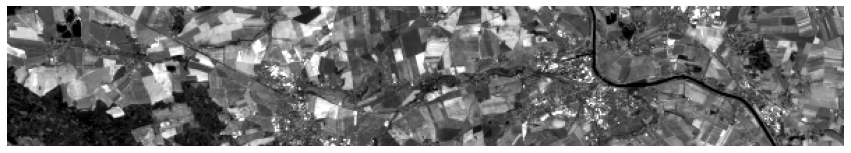

In [44]:
# Accessing the data array
class Band(str, Enum):
    """A collection of different Sentinel-2 band names."""

    B01 = "B01"
    B02 = "B02"
    B03 = "B03"
    B04 = "B04"
    B05 = "B05"
    B06 = "B06"
    B07 = "B07"
    B08 = "B08"
    B8A = "B8A"
    B09 = "B09"
    B10 = "B10"
    B11 = "B11"
    B12 = "B12"

    def __str__(self):
        return self.value


def read_s2_jp2_data(jp2_data_path: Path) -> np.ndarray:
    """
    Read band from Sentinel-2 jp2 file.
    """
    with rasterio.open(jp2_data_path) as data:
        # rasterio is 1-indexed
        return data.read(1)


def _get_all_jp2_files(source_dir: Path, parent_dir: str = "IMG_DATA/R60m") -> List[Path]:
    """
    Given a Sentinel-2 source directory, find all jp2 files that have
    a parent folder named `parent_dir`.
    Usually, it should be the folder `IMG_DATA`, other possible source
    would be the quality masks in `QI_DATA`.
    To not load band multiple times at different resolutions, by default
    the lowest 60m band is loaded.

    Note: Depending on the acquisition date and data type, the structure might be different
    and no sub-directory within `IMG_DATA` exists!
    """
    image_files = list(source_dir.glob(f"**/{parent_dir}/*.jp2"))
    assert len(image_files) > 0
    return image_files


class S2_TileReader:
    def __init__(self, safe_directory: Path, img_data_parent_dir: str = "IMG_DATA/R60m"):
        self.image_files = _get_all_jp2_files(safe_directory, parent_dir=img_data_parent_dir)

    def _get_band_path(self, band: Band) -> Path:
        return [f for f in self.image_files if f"_{band}_" in f.name][0]

    def read_band_data(self, band: Band) -> np.ndarray:
        band_path = self._get_band_path(band)
        return read_s2_jp2_data(band_path)


s2_reader = S2_TileReader(unzipped_dir)
band01_data = s2_reader.read_band_data(Band.B01)
band02_data = s2_reader.read_band_data(Band.B02)
band03_data = s2_reader.read_band_data(Band.B03)
band04_data = s2_reader.read_band_data(Band.B04)
band05_data = s2_reader.read_band_data(Band.B05)
band06_data = s2_reader.read_band_data(Band.B06)
band07_data = s2_reader.read_band_data(Band.B07)
#band08_data = s2_reader.read_band_data(Band.B08)
band09_data = s2_reader.read_band_data(Band.B09)
#band10_data = s2_reader.read_band_data(Band.B10)
band11_data = s2_reader.read_band_data(Band.B11)
band12_data = s2_reader.read_band_data(Band.B12)

print(band01_data)
print(band01_data.size)
sub_band03_data = band03_data[-100:, -600:]
vis(sub_band03_data)

print(band02_data)
print(band02_data.size)

print(band03_data)

In [22]:
band03_data.min(), band03_data.max(), band03_data.shape, band03_data.dtype

(0, 17901, (1830, 1830), dtype('uint16'))

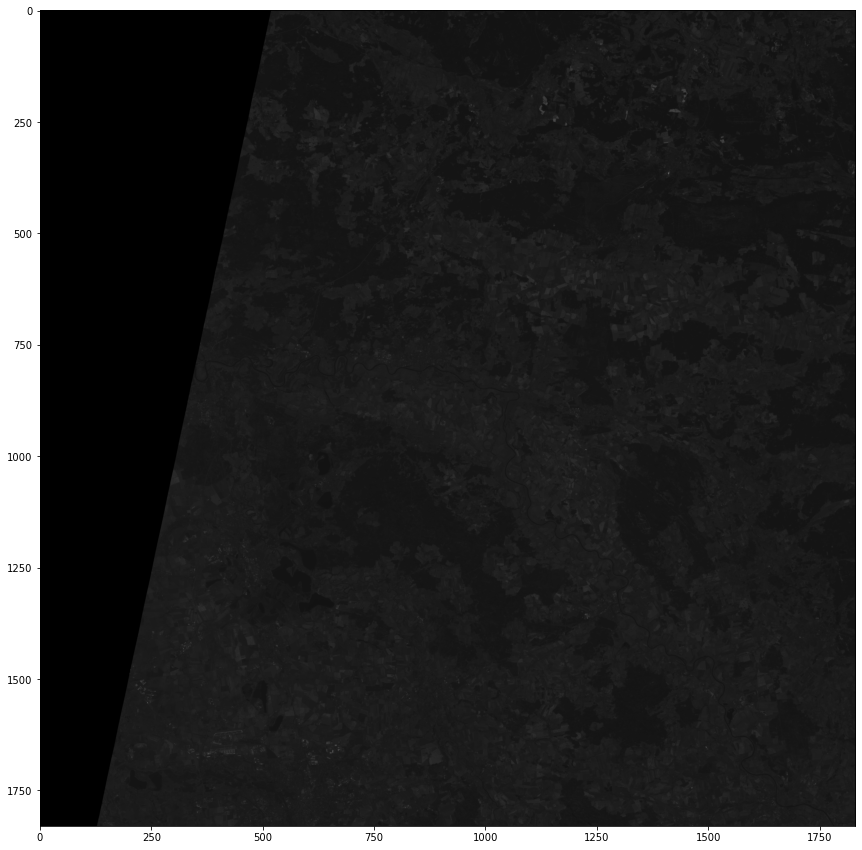

In [51]:
plt.figure(figsize=(15, 15))
plt.imshow(band03_data, cmap="gray")

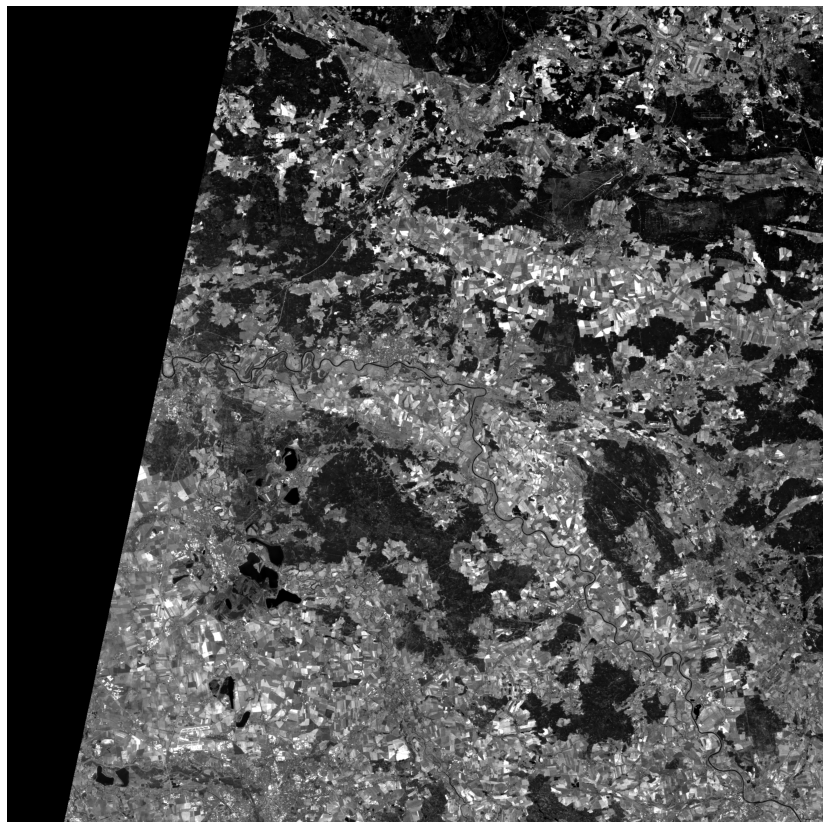

In [24]:
def quant_norm_data(
    data: np.ndarray, lower_quant: float = 0.01, upper_quant: float = 0.99
) -> np.ndarray:
    """
    Normalize the data by quantiles `lower_quant/upper_quant`.
    The quantiles are calculated globally/*across all channels*.
    """
    masked_data = np.ma.masked_equal(data, 0)
    lq, uq = np.quantile(masked_data.compressed(), (lower_quant, upper_quant))
    data = np.clip(data, a_min=lq, a_max=uq)
    data = (data - lq) / (uq - lq)
    return data


def vis(data: np.ndarray, quant_norm: bool = True):
    """
    Visualize an array by calling `imshow` with `cmap="gray"`.
    By default, the image is normalized through `quant_norm_data`.
    """
    if quant_norm:
        data = quant_norm_data(data)

    plt.figure(figsize=(15, 15))
    plt.axis("off")
    plt.imshow(data, cmap="gray")


vis(band03_data)


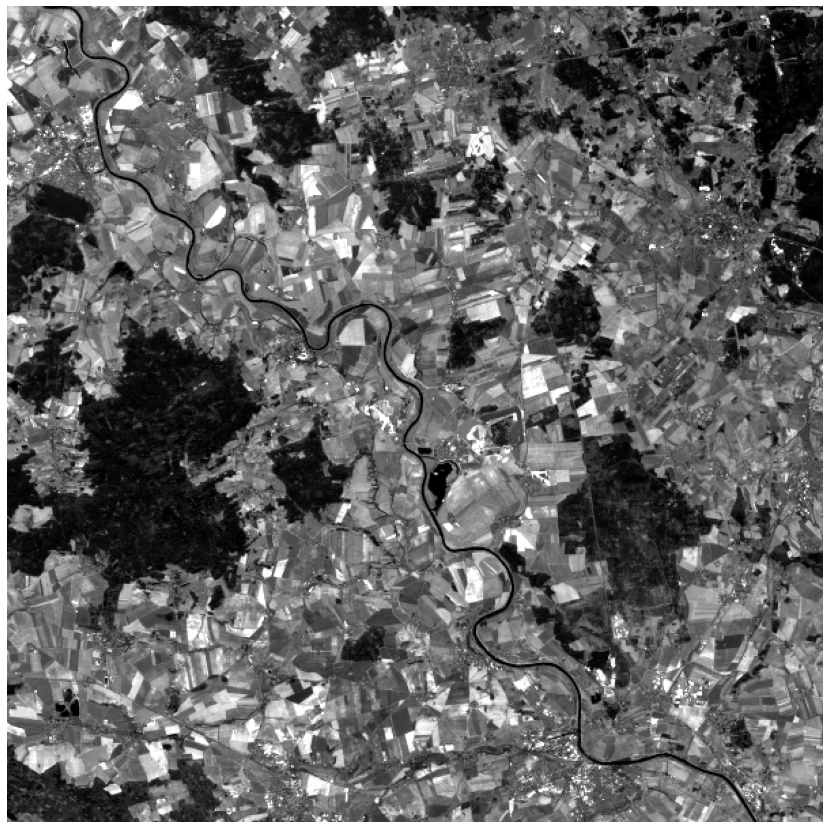

In [25]:
# vis(band03_data)
sub_band03_data = band03_data[-600:, -600:]
vis(sub_band03_data)

In [26]:
rgb_arr = np.stack(
    [s2_reader.read_band_data(b) for b in (Band.B04, Band.B03, Band.B02)],
    axis=-1,
)
rgb_arr.shape

(1830, 1830, 3)

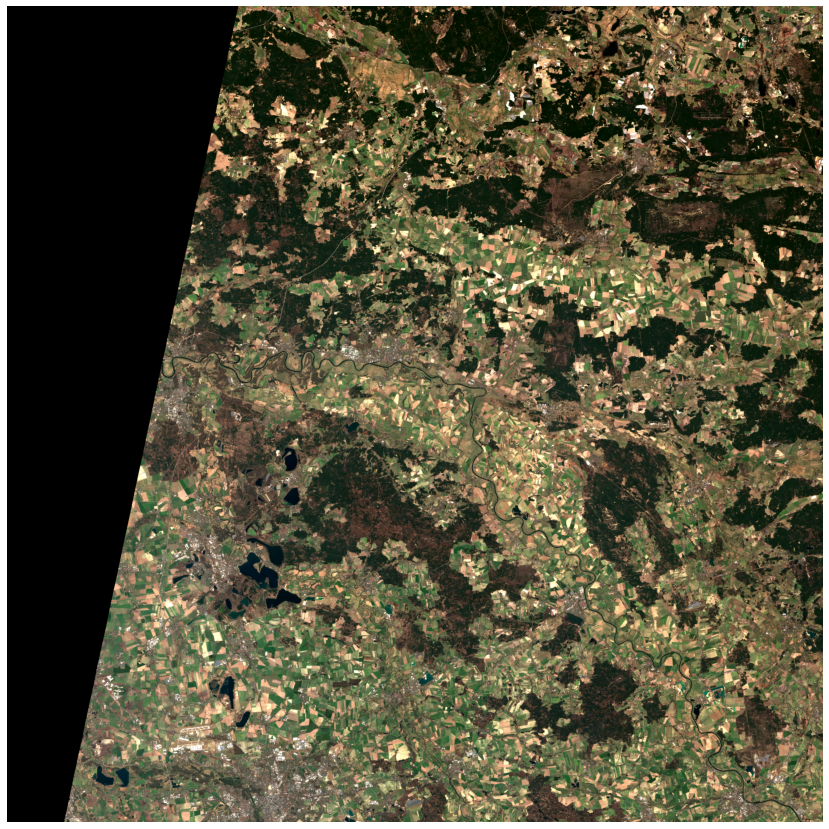

In [27]:
vis(rgb_arr)

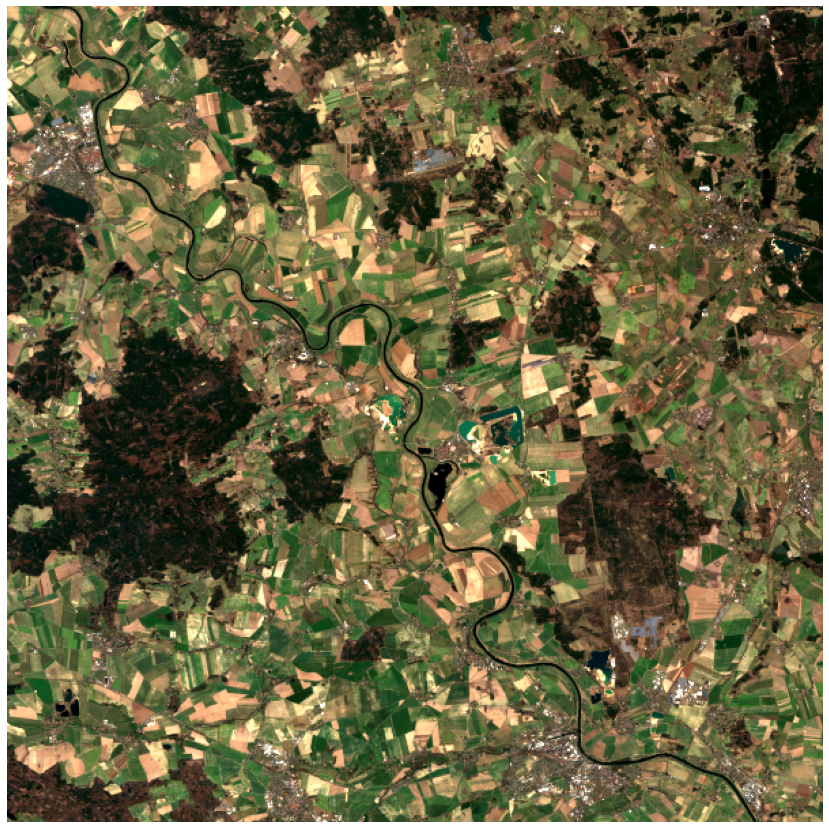

In [28]:
sub_rgb_arr = rgb_arr[-600:, -600:]
vis(sub_rgb_arr)

In [29]:
# store each channel individually with a key to
# make it easier to work with it later
np.savez(
    "data/sub_rgb_arr",
    red=sub_rgb_arr[:, :, 0],
    green=sub_rgb_arr[:, :, 1],
    blue=sub_rgb_arr[:, :, 2],
)
np.savez("data/rgb_arr", red=rgb_arr[:, :, 0], green=rgb_arr[:, :, 1], blue=rgb_arr[:, :, 2])

In [54]:
berlin_gdf = osmnx.geocode_to_gdf("Moabit")
berlin_gdf

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


geometry  bbox_north  bbox_south  \
0  POLYGON ((13.31143 52.53562, 13.31150 52.53540...    52.54143   52.516668   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat        lon  \
0  13.373856  13.311428  281973740  relation   28339  52.530102  13.342542   

                     display_name     class            type  importance  
0  Moabit, Mitte, Berlin, Germany  boundary  administrative     0.57633

In [55]:
berlin_gdf.explore()

In [ ]:
### Add here the code to select a valid subregion

subregion_uint8 = ...

In [ ]:
### DO NOT EDIT
submission_subregion_uint8 = deepcopy(subregion_uint8)
###

### Visualize the valid sub-region

Visualize a _single band_ from the valid subregion _without_ applying any explicit or implicit normalization strategy.
The input array passed to `plt.imshow` has to be in the range `[0, 255]`. This range should also be reflected in the `vmin/vmax` parameters.

In [ ]:
# Add the code to visualize the single band
# without normalization here:

# imshow_inp is the array that should be passed to plt.imshow
imshow_inp = ...

In [ ]:
# DO NOT EDIT
submission_imshow_inp = deepcopy(imshow_inp)
###

## Morphological operators & Thresholding

The goal of this section is to combine morphological operators with thresholding strategies to create a binary/output mask that can then be used to segment the region/object of interest.
You are _not_ required to perfectly segment the object of interest. It is sufficient if the visual results _indicate_ the object of interest.

You have to meet the following requirements:
- You are _not_ allowed to use simple rectangular structuring elements.
- The values of the output mask must either be 0 or 1
    - 0 is used to indicate the absence of the object
    - 1 is used to indicate the presence of the object

In [ ]:
# Add code here to apply morphological operators
# and thresholding strategy
# You are allowed to change/mix the order

output_mask = ...

In [ ]:
# DO NOT EDIT
submission_output_mask = deepcopy(output_mask)
###

To visually evaluate your result, use the output mask as an overlay for the RGB channels of the input array.
The colored output should be normalized to enhance the viewing experiment.
You can choose any _valid_ normalization strategy/method for the RGB channels.

In [ ]:
# Visualize the overlayed image

### Discussion

Discuss what you have learned when applying the morphological operators and thresholding strategies.
What didn't work? What issues did you have? What helped?
How did you decide to use the variables you have chosen?

It is not necessary to give an in-depth discussion about each value.
It should be clear, however, that you have tried different configurations and why you have decided on the current configuration.

Here you should write discussion:

## Submission

- Follow the instructions mentioned in this notebook.
- You are _not_ allowed to install other libraries.
    - The submitted jupyter notebook should be able to run as-is on paperspace and/or the provided Docker image.
- Explain the steps that went into the decision making of the specific values.
- It is essential that each homework should be done individually!
- The notebook should have been executed once before submitting it
    - The notebook should _not_ be _cleaned_ before submitting

Each student should submit the following materials to the ISIS system:
- One `zip` file containing the jupyter notebook named as: `IP4RS2022-HW1_<NAME_SURNAME>.zip`



### Submission variables

Please ensure that these variables are correct after you have restarted your notebook and executed all cells from top to bottom.
You are _not allowed_ to modify the following cells:

In [ ]:
import rich

rich.print(f"{submission_tile_id=}")
rich.print(f"{submission_subregion_uint8=}")
rich.print(f"{submission_output_mask=}")